Using device: cuda
Loaded trained model ✅
Accuracy on normal test set: 96.86%
Accuracy on shifted test set: 46.81%


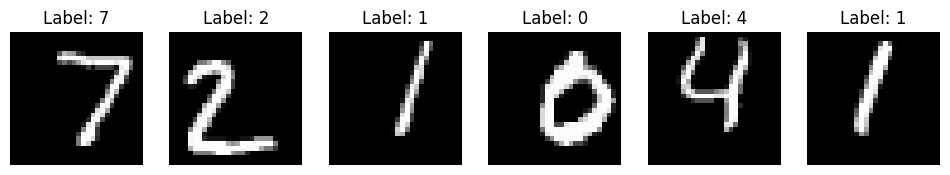

In [2]:
# ====== 1. Imports ======
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ====== 2. Define MLP (same as in Notebook 2) ======
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)

model = MLP().to(device)

# ====== 3. Load trained model ======
# If you saved the model in 02_mlp_mnist.ipynb, load it here
# Otherwise, retrain briefly (not recommended for demo speed)
try:
    model.load_state_dict(torch.load("../data/mlp_mnist.pth"))
    print("Loaded trained model ✅")
except FileNotFoundError:
    print("⚠️ Model not found, please run 02_mlp_mnist.ipynb and save it.")

# ====== 4. Create normal and shifted test datasets ======
transform_normal = transforms.ToTensor()

transform_shifted = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),  # shift by up to 15%
    transforms.ToTensor()
])

test_normal = datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=transform_normal
)

test_shifted = datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=transform_shifted
)

loader_normal = DataLoader(test_normal, batch_size=1000, shuffle=False)
loader_shifted = DataLoader(test_shifted, batch_size=1000, shuffle=False)

# ====== 5. Evaluation function ======
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total

# ====== 6. Run evaluations ======
acc_normal = evaluate(model, loader_normal)
acc_shifted = evaluate(model, loader_shifted)

print(f"Accuracy on normal test set: {acc_normal:.2f}%")
print(f"Accuracy on shifted test set: {acc_shifted:.2f}%")

# ====== 7. Visualize some shifted samples ======
fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    img, label = test_shifted[i]
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.show()
